### Food Delivery time prediction

#### load libraries and data:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , accuracy_score
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [3]:
df = pd.read_excel('Food Delivery Time Prediction Case Study.xlsx')

In [4]:
df.sample(5)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
39599,66FE,MYSRES06DEL03,36,4.7,12.323994,76.626167,12.413994,76.716167,Drinks,scooter,29
34948,5073,MUMRES15DEL02,25,4.9,19.176269,72.836721,19.306269,72.966721,Snack,scooter,23
25013,9EF7,RANCHIRES08DEL01,31,4.5,23.353783,85.326967,23.393783,85.366967,Snack,electric_scooter,28
35394,A264,MYSRES18DEL03,30,4.8,12.337928,76.617889,12.427928,76.707889,Snack,motorcycle,40
26550,D8C0,KNPRES05DEL02,30,5.0,26.479108,80.315042,26.609108,80.445042,Snack,electric_scooter,41


#### Check for any null values

In [5]:
df.isnull().sum()    

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Type_of_order                  0
Type_of_vehicle                0
Time_taken(min)                0
dtype: int64

#### Some of columns are useless here, like id and type of order 

In [6]:
vehicle_type = df['Type_of_vehicle'].unique().tolist()
vehicle_type 

['motorcycle ', 'scooter ', 'electric_scooter ', 'bicycle ']

## Data Processing

In [7]:
# I am keeping vehicle_type  column as bicycle is way slower than other vehicles
df = df.drop(columns = ['ID','Delivery_person_ID','Type_of_order'])

In [8]:
df.sample(5)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_vehicle,Time_taken(min)
25344,38,4.8,13.058616,80.264151,13.148616,80.354151,scooter,17
45455,22,4.7,19.003517,72.827650,19.033517,72.857650,scooter,25
39640,34,5.0,12.352058,76.606650,12.382058,76.636650,motorcycle,30
24762,32,4.8,23.374989,85.335486,23.454989,85.415486,motorcycle,24
12260,30,5.0,19.875016,75.322405,19.925016,75.372405,electric_scooter,25


In [9]:
def distcalculate(lat1, lat2, lon1, lon2):
	# radians which converts from degrees to radians.
	lon1 = radians(lon1)
	lon2 = radians(lon2)
	lat1 = radians(lat1)
	lat2 = radians(lat2)
	
	# Haversine formula 
	dlon = lon2 - lon1 
	dlat = lat2 - lat1
	a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
	c = 2 * asin(sqrt(a)) 
	r = 6371
	return(c * r)

df['distance'] = df.apply(lambda row: distcalculate(row['Restaurant_latitude'], 
                                                    row['Delivery_location_latitude'], 
                                                    row['Restaurant_longitude'], 
                                                    row['Delivery_location_longitude']), axis=1)

In [10]:
df.sample(5)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_vehicle,Time_taken(min),distance
10201,21,4.5,21.186884,72.793616,21.216884,72.823616,electric_scooter,17,4.560734
13711,38,4.5,11.022169,76.999594,11.052169,77.029594,electric_scooter,15,4.674175
1477,22,4.9,23.359407,85.325055,23.419407,85.385055,scooter,24,9.055849
6363,24,4.0,22.751857,75.866699,22.761857,75.876699,motorcycle,18,1.512565
23190,34,4.8,15.544419,73.755736,15.674419,73.885736,motorcycle,40,20.069492


#### Data Exploration

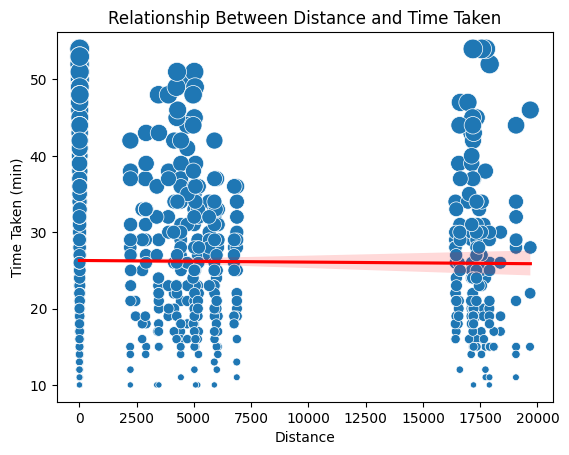

In [11]:
sns.scatterplot(data=df, x="distance", y="Time_taken(min)", size="Time_taken(min)", sizes=(20, 200), legend=False)
sns.regplot(data=df, x="distance", y="Time_taken(min)", scatter=False, color='red')
plt.title("Relationship Between Distance and Time Taken")
plt.xlabel("Distance")
plt.ylabel("Time Taken (min)")
plt.show()

#### Outlier Handling

In [12]:
# There are outliers in data. So we are gonna throw datapoints where distance >100 kms

In [13]:
df = df[df['distance'] < 1000]

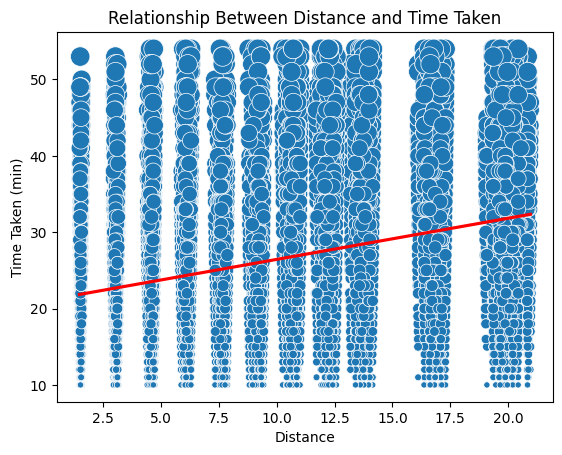

In [14]:
sns.scatterplot(data=df, x="distance", y="Time_taken(min)", size="Time_taken(min)", sizes=(20, 200), legend=False)
sns.regplot(data=df, x="distance", y="Time_taken(min)", scatter=False, color='red')
plt.title("Relationship Between Distance and Time Taken")
plt.xlabel("Distance")
plt.ylabel("Time Taken (min)")
plt.show()

In [ ]:
# Weird graph tho. 

In [15]:
max(df['distance']) , min(df['distance'])

(20.969489380087342, 1.4650674052309467)

In [16]:
# Since we now have distance available, we dont need latitudes and longitudes
df = df.drop(columns=['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'])

In [17]:
min(df['Time_taken(min)']), max(df['Time_taken(min)'])

(10, 54)

#### Lets apply columnTransformer , train_test_split and OneHotEncoding for Type_of_vehicle 

In [18]:
X = df.drop('Time_taken(min)', axis=1)
y = df['Time_taken(min)']

In [19]:
X_train, X_test , y_train , y_test = train_test_split(X,y , test_size = 0.2 , random_state = 1)

In [20]:
ct = ColumnTransformer(transformers=[('tf',OneHotEncoder(drop='first',handle_unknown='ignore'),['Type_of_vehicle'])],remainder='passthrough')

In [21]:
X_train_encoded = ct.fit_transform(X_train)
X_test_encoded = ct.transform(X_test)

#### Scaling with StandardScalar

In [22]:
scalar = StandardScaler()
scalar.fit(X_train_encoded);

In [23]:
X_train = scalar.transform(X_train_encoded)
X_test = scalar.transform(X_test_encoded)

#### Applying LinearRegression

In [24]:
model = LinearRegression()
model.fit(X_train , y_train);

In [25]:
y_pred = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test , y_pred))
print("Root mean squared error:", rmse)

Root mean squared error: 7.874096855961578


#### applying randomforest

In [26]:
forest = RandomForestRegressor(random_state=1)
forest.fit(X_train, y_train);

In [27]:
y_pred2 = forest.predict(X_test)
mse = mean_squared_error(y_test, y_pred2)
rmse = sqrt(mse)
print("Root mean Squared Error:", rmse)

Root mean Squared Error: 7.96054362140233


#### Applying Gradient Boosting

In [28]:
gradient_boosting_model = GradientBoostingRegressor(random_state=1)
gradient_boosting_model.fit(X_train, y_train);

In [29]:
gradient_boosting_y_pred = gradient_boosting_model.predict(X_test)
gradient_boosting_rmse = sqrt(mean_squared_error(y_test, gradient_boosting_y_pred))
print("Gradient Boosting Root Mean Squared Error:", gradient_boosting_rmse)

Gradient Boosting Root Mean Squared Error: 7.220311818530024


#### Applying KNN

In [30]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train);

In [31]:
knn_y_pred = knn_model.predict(X_test)
knn_rmse = sqrt(mean_squared_error(y_test, knn_y_pred))
print("KNN Root Mean Squared Error:", knn_rmse)

KNN Root Mean Squared Error: 7.864452814219649


#### Applying xgboost

In [32]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train);

In [33]:
y_pred = xgb_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("XGBoost Root Mean Squared Error:", rmse)

XGBoost Root Mean Squared Error: 7.302650792996401
